In [1]:
%pylab inline
import matplotlib.gridspec as gridspec
from astropy.cosmology import WMAP9
from simqso.sqgrids import *
from simqso import sqbase
from simqso import hiforest
from simqso.sqrun import buildSpectraBySightLine,buildQsoSpectrum
from simqso import sqphoto
from simqso import sqmodels

Populating the interactive namespace from numpy and matplotlib


In [2]:
# cover 3000A to 5um at R=500
wave = sqbase.fixed_R_dispersion(3000,5e4,500)

In [3]:
forestModel = sqmodels.forestModels['McGreer+2013']
forestSpec = hiforest.IGMTransmissionGrid(wave,forestModel,100,zmax=5.3)
forestVar = HIAbsorptionVar(forestSpec)

## Lya/dust

In [2]:
M = AbsMagVar(UniformSampler(-29,-24),restWave=1450)
z = RedshiftVar(UniformSampler(4.7,5.3))
lya = GaussianLineEqWidthVar(FixedSampler([0.,15,60,120]),'LyaEW',1215.67,10.)
dust = SMCDustVar(UniformSampler(0,0.2))
qsoGrid = QsoSimGrid([M,z,lya,dust],(10,5,4,5),50,fixed_vars=['LyaEW','smcDustEBV'],
                     cosmo=WMAP9,units='luminosity')

In [3]:
qsoGrid.gridShape,len(qsoGrid.data)

((10, 5, 4, 5, 50), 50000)

In [6]:
# the "expdust" continuum model from Ross+13
contVar = BrokenPowerLawContinuumVar([GaussianSampler(-0.5,0.2),
                                      GaussianSampler(-0.3,0.2)],
                                     [1100.])
# generate lines using the Baldwin Effect emission line model from BOSS DR9
emLineVar = generateBEffEmissionLines(qsoGrid.absMag,ExcludeLines=['LyAn','LyAb'])
# the default iron template from Vestergaard & Wilkes 2001 was modified to fit BOSS spectra
fescales = [(0,1540,0.5),(1540,1680,2.0),(1680,1868,1.6),(1868,2140,1.0),(2140,3500,1.0)]
feVar = FeTemplateVar(VW01FeTemplateGrid(qsoGrid.z,wave,scales=fescales))
# Now add the features to the QSO grid
qsoGrid.addVars([contVar,emLineVar,feVar,forestVar])

using Fe scales:  [(0, 1540, 0.5), (1540, 1680, 2.0), (1680, 1868, 1.6), (1868, 2140, 1.0), (2140, 3500, 1.0)]


In [7]:
qsoGrid.loadPhotoMap([('SDSS','Legacy'),('UKIRT','UKIDSS_LAS')])

In [8]:
# ready to generate spectra
_ = buildSpectraBySightLine(wave,qsoGrid,verbose=5)

simulating  50000  quasar spectra
units are  luminosity
max number iterations:  1
processing  498  obj in group  0


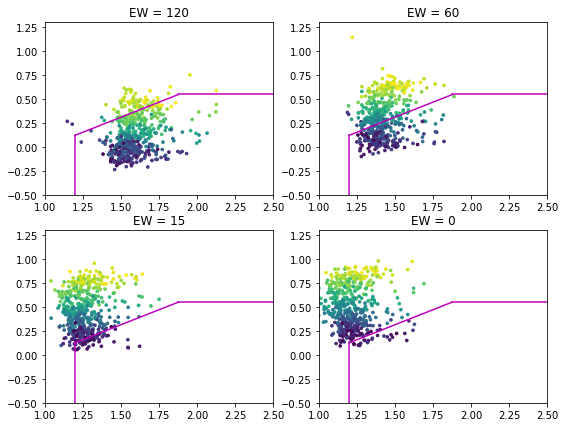

In [19]:
g_mags = qsoGrid.asGrid('synMag')
g_z = qsoGrid.asGrid('z')
figure(figsize=(9,7))
for ew_i in range(4):
    ax = subplot(2,2,ew_i+1)
    scatter(g_mags[:,:,3-ew_i,0,::5,2]-g_mags[:,:,3-ew_i,0,::5,3],
            g_mags[:,:,3-ew_i,0,::5,3]-g_mags[:,:,3-ew_i,0,::5,4],
           c=g_z[:,:,3-ew_i,0,::5],s=7)
    ax.set_title('EW = %d' % qsoGrid.gridCenters[2][3-ew_i])
    ax.plot([1.2,1.2],[-0.5,0.13],c='m')
    ax.plot([1.875,2.5],[0.55,0.55],c='m')
    ri = linspace(1.2,1.875,2)
    ax.plot(ri,polyval([0.625,0],ri-1),c='m')
    ax.set_xlim(1.0,2.5)
    ax.set_ylim(-0.5,1.3)

In [15]:
photoData = sqphoto.calcObsPhot(qsoGrid.synFlux,qsoGrid.photoMap)
qsoGrid.addData(photoData)

In [16]:
#g_mags = qsoGrid.asGrid('obsMag')
g_mags = qsoGrid.asGrid('synMag')
r_minus_i = g_mags[...,2] - g_mags[...,3]
i_minus_z = g_mags[...,3] - g_mags[...,4]
color_sel = ( (r_minus_i>1.2) & 
              (i_minus_z < 0.625*(r_minus_i-1)) &
              (i_minus_z<0.55)
            )

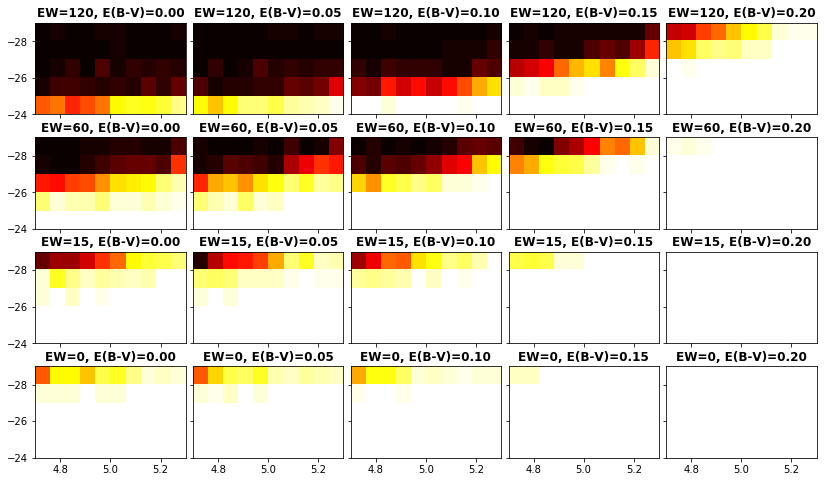

In [17]:
gs = gridspec.GridSpec(4,5)
gs.update(wspace=0.05,hspace=0.25)
figure(figsize=(14,8))
for i in range(4):
    for j in range(5):
        ax = plt.subplot(gs[i,j])
        if j>0: ax.yaxis.set_ticklabels([])
        if i<3: ax.xaxis.set_ticklabels([])
        fsel = color_sel[:,:,-(i+1),j].sum(axis=-1) / 50.
        imshow(fsel.T,vmin=0,vmax=1,extent=[4.7,5.3,-24,-29],
               interpolation='nearest',aspect='auto',cmap=cm.hot_r)
        title('EW=%d, E(B-V)=%.2f' %
              (qsoGrid.gridCenters[2][-(i+1)],qsoGrid.gridCenters[3][j]),
              size=12,weight='bold')

[750 850 950]


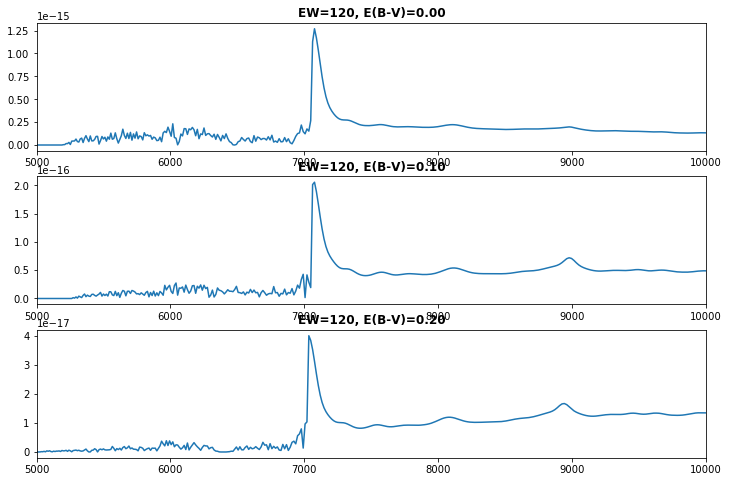

In [18]:
specFeatures = qsoGrid.getVars(SpectralFeatureVar)
ii = np.array([np.ravel_multi_index(t,qsoGrid.gridShape)
               for t in [(0,0,3,0,0),(0,0,3,2,0),(0,0,3,4,0)]])
print ii
figure(figsize=(12,8))
for _i,i in enumerate(ii):
    subplot(3,1,_i+1)
    obj = qsoGrid.data[i]
    sp = buildQsoSpectrum(wave,qsoGrid.cosmo,specFeatures,obj)
    plot(wave,sp.f_lambda)
    title('EW=%d, E(B-V)=%.2f' %
              (obj['LyaEW'],obj['smcDustEBV']),size=12,weight='bold')
    xlim(5000,1e4)

## Lya/continuum

Now make a 4-d grid where the last two dimensions are Lya strength and continuum shape.

In [4]:
M = AbsMagVar(UniformSampler(-29,-24),restWave=1450)
z = RedshiftVar(UniformSampler(4.7,5.3))
lya = GaussianLineEqWidthVar(FixedSampler([0.,15,30,60,120]),'LyaEW',1215.67,5.0)
uvslope = QsoSimVar(FixedSampler([-1.5,-1.0,-0.6,-0.4,-0.2,0.0]),'uvslope')
qsoGrid = QsoSimGrid([M,z,lya,uvslope],(10,5,5,6),50,fixed_vars=['LyaEW','uvslope'],
                     cosmo=WMAP9,units='luminosity')

In [5]:
contVar = BrokenPowerLawContinuumVar([ConstSampler(-1.5),
                                      FixedSampler(qsoGrid.uvslope)],[1100.])
qsoGrid.addVars([contVar,forestVar])

In [6]:
qsoGrid.loadPhotoMap([('SDSS','Legacy'),('UKIRT','UKIDSS_LAS')])

In [7]:
# ready to generate spectra
_ = buildSpectraBySightLine(wave,qsoGrid,verbose=5)

simulating  75000  quasar spectra
units are  luminosity
max number iterations:  1
processing  740  obj in group  0


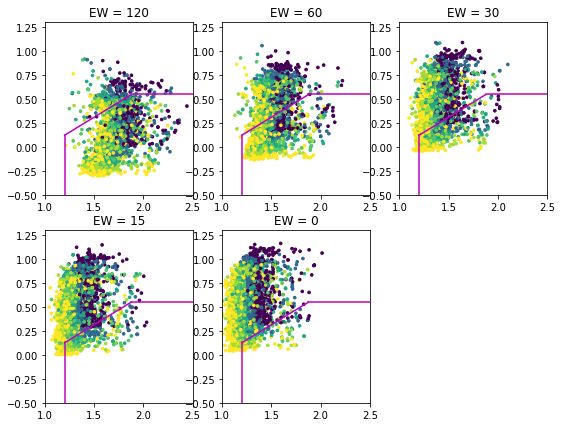

In [8]:
g_mags = qsoGrid.asGrid('synMag')
g_z = qsoGrid.asGrid('z')
g_a = qsoGrid.asGrid('uvslope')
figure(figsize=(9,7))
for ew_i in range(5):
    ax = subplot(2,3,ew_i+1)
    scatter(g_mags[:,:,4-ew_i,:,::5,2]-g_mags[:,:,4-ew_i,:,::5,3],
            g_mags[:,:,4-ew_i,:,::5,3]-g_mags[:,:,4-ew_i,:,::5,4],
           c=g_a[:,:,4-ew_i,:,::5],s=7)
    ax.set_title('EW = %d' % qsoGrid.gridCenters[2][4-ew_i])
    ax.plot([1.2,1.2],[-0.5,0.13],c='m')
    ax.plot([1.875,2.5],[0.55,0.55],c='m')
    ri = linspace(1.2,1.875,2)
    ax.plot(ri,polyval([0.625,0],ri-1),c='m')
    ax.set_xlim(1.0,2.5)
    ax.set_ylim(-0.5,1.3)

In [9]:
photoData = sqphoto.calcObsPhot(qsoGrid.synFlux,qsoGrid.photoMap)
qsoGrid.addData(photoData)

In [10]:
#g_mags = qsoGrid.asGrid('obsMag')
g_mags = qsoGrid.asGrid('synMag')
r_minus_i = g_mags[...,2] - g_mags[...,3]
i_minus_z = g_mags[...,3] - g_mags[...,4]
color_sel = ( (r_minus_i>1.2) & 
              (i_minus_z < 0.625*(r_minus_i-1)) &
              (i_minus_z<0.55)
            )

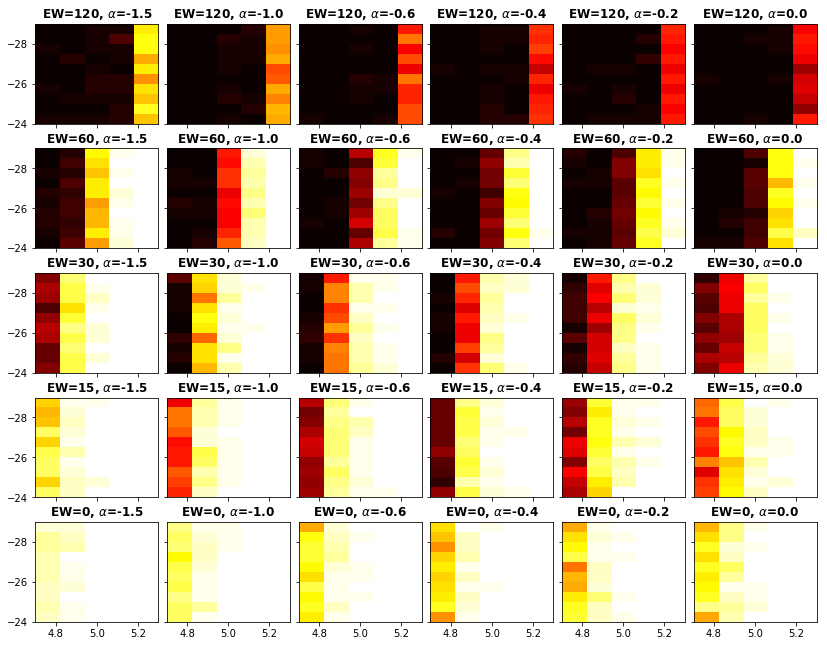

In [14]:
gs = gridspec.GridSpec(5,6)
gs.update(wspace=0.07,hspace=0.25)
figure(figsize=(14,11))
for i in range(5):
    for j in range(6):
        ax = plt.subplot(gs[i,j])
        if j>0: ax.yaxis.set_ticklabels([])
        if i<4: ax.xaxis.set_ticklabels([])
        fsel = color_sel[:,:,-(i+1),j].sum(axis=-1) / 50.
        imshow(fsel,vmin=0,vmax=1,extent=[4.7,5.3,-24,-29],
               interpolation='nearest',aspect='auto',cmap=cm.hot_r)
        title(r'EW=%d, $\alpha$=%.1f' %
              (qsoGrid.gridCenters[2][-(i+1)],qsoGrid.gridCenters[3][j]),
              size=12,weight='bold')

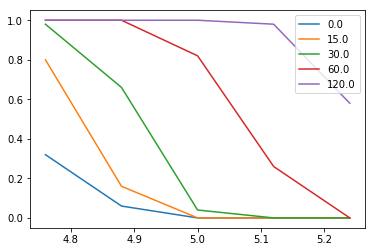

In [15]:
fsel = color_sel[5,:,:,3].sum(axis=-1) / 50.
lobj = plot(qsoGrid.gridCenters[1],fsel)
legend(iter(lobj),['%.1f'%a for a in qsoGrid.gridCenters[2]])

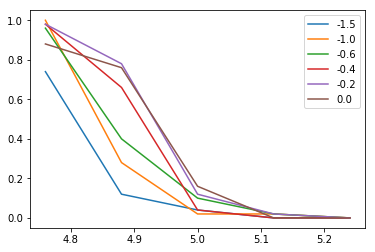

In [16]:
fsel = color_sel[5,:,2].sum(axis=-1) / 50.
lobj = plot(qsoGrid.gridCenters[1],fsel)
legend(iter(lobj),['%.1f'%a for a in qsoGrid.gridCenters[3]])